# Semantic Segmentation: SegFormer finetuned on SceneParse150

## Setup

In [25]:
import json

import numpy as np

import torch
from torch import nn
from torchvision.transforms import ColorJitter

from huggingface_hub import cached_download, hf_hub_url
from transformers import (
    AutoImageProcessor,
    AutoModelForSemanticSegmentation,
    TrainingArguments,
    Trainer,
    pipeline
)
from datasets import load_dataset
import evaluate

import albumentations as A

In [2]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/mmenendezg/.cache/huggingface/token
Login successful


In [3]:
MODEL_CHECKPOINT = "nvidia/mit-b0"

## Load SceneParse150 dataset

In [4]:
dataset = load_dataset("scene_parse_150", split="train[:50]")

dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]
del dataset

In [5]:
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type="dataset")), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

/Users/mmenendezg/Developer/Projects/semantic-segmentation/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:649: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


## Preprocess

In [6]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT, reduce_labels=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/mmenendezg/Developer/Projects/semantic-segmentation/.venv/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [7]:
jitter = ColorJitter(
    brightness=0.25,
    contrast=0.25,
    saturation=0.25,
    hue=0.1
)

def train_transforms(batch):
    images = [jitter(image) for image in batch["image"]]
    labels = [mask for mask in batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(batch):
    images = [img for img in batch["image"]]
    labels = [mask for mask in batch["annotation"]]
    inputs = image_processor(images, labels)
    return inputs

In [8]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Evaluate

In [9]:
# Create the metric to evaluate the model during training
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)
        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
    
    return metrics

## Train

In [11]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    id2label=id2label,
    label2id=label2id
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
training_args = TrainingArguments(
    output_dir="segformer-b0_scene_parse_150",
    report_to=["tensorboard"],
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=True
)

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

In [40]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 2.9856, 'learning_rate': 5.994e-05, 'epoch': 0.05}
{'loss': 3.2247, 'learning_rate': 5.988e-05, 'epoch': 0.1}
{'loss': 3.5003, 'learning_rate': 5.982e-05, 'epoch': 0.15}
{'loss': 3.0613, 'learning_rate': 5.9760000000000004e-05, 'epoch': 0.2}
{'loss': 2.8533, 'learning_rate': 5.97e-05, 'epoch': 0.25}
{'loss': 3.2358, 'learning_rate': 5.964e-05, 'epoch': 0.3}
{'loss': 3.0429, 'learning_rate': 5.958e-05, 'epoch': 0.35}
{'loss': 2.8589, 'learning_rate': 5.952e-05, 'epoch': 0.4}
{'loss': 3.3526, 'learning_rate': 5.946e-05, 'epoch': 0.45}
{'loss': 2.6204, 'learning_rate': 5.94e-05, 'epoch': 0.5}
{'loss': 3.1569, 'learning_rate': 5.934e-05, 'epoch': 0.55}
{'loss': 2.9891, 'learning_rate': 5.928e-05, 'epoch': 0.6}
{'loss': 3.0158, 'learning_rate': 5.922e-05, 'epoch': 0.65}
{'loss': 3.5287, 'learning_rate': 5.916e-05, 'epoch': 0.7}
{'loss': 3.6151, 'learning_rate': 5.91e-05, 'epoch': 0.75}
{'loss': 3.6289, 'learning_rate': 5.9040000000000004e-05, 'epoch': 0.8}
{'loss': 3.1968, 'learnin

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17082135046238095, 0.0013790237267643948, 0.0013295170609474859, 0.0, 0.0, 0.006706581267984776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan

{'eval_loss': 4.167970180511475, 'eval_mean_iou': 0.004096283466319946, 'eval_mean_accuracy': 0.022859329738720468, 'eval_overall_accuracy': 0.1705660144705086, 'eval_per_category_iou': [0.17082135046238095, 0.0013790237267643948, 0.0013295170609474859, 0.0, 0.0, 0.006706581267984776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17045614380252436, 0.004807164249049917, 0.0020688009856180945, 0.0, 0.0, 0.003860700272843787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 4.162510871887207, 'eval_mean_iou': 0.004118018393409913, 'eval_mean_accuracy': 0.02279080892741068, 'eval_overall_accuracy': 0.17016997859693694, 'eval_per_category_iou': [0.17045614380252436, 0.004807164249049917, 0.0020688009856180945, 0.0, 0.0, 0.003860700272843787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17008452723558704, 0.013260992349427491, 0.0060229067930489735, 0.0, 0.0, 0.0012086962090163934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan

{'eval_loss': 3.808173656463623, 'eval_mean_iou': 0.004331298240615452, 'eval_mean_accuracy': 0.02280924767732112, 'eval_overall_accuracy': 0.16986342542344798, 'eval_per_category_iou': [0.17008452723558704, 0.013260992349427491, 0.0060229067930489735, 0.0, 0.0, 0.0012086962090163934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17040423845838318, 0.004022074989601283, 0.0003933544552755984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, n

{'eval_loss': 4.832752227783203, 'eval_mean_iou': 0.003973174270528638, 'eval_mean_accuracy': 0.022735432236902452, 'eval_overall_accuracy': 0.17037206392918108, 'eval_per_category_iou': [0.17040423845838318, 0.004022074989601283, 0.0003933544552755984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17035168313790588, 0.007531763375900518, 0.0025327187364191416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, n

{'eval_loss': 4.179113864898682, 'eval_mean_iou': 0.004100367392050581, 'eval_mean_accuracy': 0.022766554266534733, 'eval_overall_accuracy': 0.17027059311616866, 'eval_per_category_iou': [0.17035168313790588, 0.007531763375900518, 0.0025327187364191416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17116257391557935, 0.0031332447689325013, 0.008649344528120042, 0.0, 0.0, 0.007088860362287833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 4.639647483825684, 'eval_mean_iou': 0.004318955081248176, 'eval_mean_accuracy': 0.022959554458727997, 'eval_overall_accuracy': 0.17070559035676197, 'eval_per_category_iou': [0.17116257391557935, 0.0031332447689325013, 0.008649344528120042, 0.0, 0.0, 0.007088860362287833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17100505222217652, 0.0, 0.008612137203166228, 0.0, 0.0, 0.003370974721179213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, na

{'eval_loss': 4.8996782302856445, 'eval_mean_iou': 0.004158821912420954, 'eval_mean_accuracy': 0.02281372520395589, 'eval_overall_accuracy': 0.170300563398493, 'eval_per_category_iou': [0.17100505222217652, 0.0, 0.008612137203166228, 0.0, 0.0, 0.003370974721179213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_cat

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17173606285908435, 7.634228828374902e-06, 0.005404810352235965, 0.0, 0.0, 0.019635801919020885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 4.881464958190918, 'eval_mean_iou': 0.004472370667253854, 'eval_mean_accuracy': 0.02314798388919488, 'eval_overall_accuracy': 0.1702187873424366, 'eval_per_category_iou': [0.17173606285908435, 7.634228828374902e-06, 0.005404810352235965, 0.0, 0.0, 0.019635801919020885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, n

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1718472727623168, 0.0001602918838876125, 0.005027600428001502, 0.0, 0.0, 0.013974293772250219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 

{'eval_loss': 4.067370414733887, 'eval_mean_iou': 0.004341124064692185, 'eval_mean_accuracy': 0.022951676956905677, 'eval_overall_accuracy': 0.16962280687107256, 'eval_per_category_iou': [0.1718472727623168, 0.0001602918838876125, 0.005027600428001502, 0.0, 0.0, 0.013974293772250219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17164017094277384, 0.0, 0.000925687653685595, 0.0, 0.0, 0.012202011072195233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, na

{'eval_loss': 5.646371364593506, 'eval_mean_iou': 0.004199269765196697, 'eval_mean_accuracy': 0.022891563442885354, 'eval_overall_accuracy': 0.16985700322009276, 'eval_per_category_iou': [0.17164017094277384, 0.0, 0.000925687653685595, 0.0, 0.0, 0.012202011072195233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_c

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17181116044725617, 3.816837597377069e-05, 0.00017547880645762007, 0.00017951888937647105, 0.0, 0.008704215883424838, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan

{'eval_loss': 4.721562385559082, 'eval_mean_iou': 0.004111557781874746, 'eval_mean_accuracy': 0.02273440055372138, 'eval_overall_accuracy': 0.16914842011656728, 'eval_per_category_iou': [0.17181116044725617, 3.816837597377069e-05, 0.00017547880645762007, 0.00017951888937647105, 0.0, 0.008704215883424838, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17197778190510676, 0.004139666139098754, 0.0025574808991489333, 0.0012145466853826319, 0.0, 0.021536396223989947, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0

{'eval_loss': 5.6369781494140625, 'eval_mean_iou': 0.004577860723925614, 'eval_mean_accuracy': 0.023056959098904393, 'eval_overall_accuracy': 0.16808875656295663, 'eval_per_category_iou': [0.17197778190510676, 0.004139666139098754, 0.0025574808991489333, 0.0012145466853826319, 0.0, 0.021536396223989947, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17265072254800087, 0.024366602045591282, 0.007541579216564666, 0.0005087129562207615, 0.0, 0.032730407904810285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.

{'eval_loss': 5.278915882110596, 'eval_mean_iou': 0.005404500560708816, 'eval_mean_accuracy': 0.023659769350746044, 'eval_overall_accuracy': 0.16654228999502066, 'eval_per_category_iou': [0.17265072254800087, 0.024366602045591282, 0.007541579216564666, 0.0005087129562207615, 0.0, 0.032730407904810285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17300128833175613, 0.027269371964119767, 0.02531483988430957, 0.0017606159171615291, 0.0, 0.039838783799598675, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0

{'eval_loss': 5.008042335510254, 'eval_mean_iou': 0.006072384088566946, 'eval_mean_accuracy': 0.024302048511210924, 'eval_overall_accuracy': 0.16529210107520528, 'eval_per_category_iou': [0.17300128833175613, 0.027269371964119767, 0.02531483988430957, 0.0017606159171615291, 0.0, 0.039838783799598675, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17287749901600985, 0.04188997046921142, 0.03055849293071711, 0.003437738731856379, 0.0, 0.021578600871362857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 

{'eval_loss': 4.789895534515381, 'eval_mean_iou': 0.006144143227708127, 'eval_mean_accuracy': 0.02390770390986013, 'eval_overall_accuracy': 0.1690777758796599, 'eval_per_category_iou': [0.17287749901600985, 0.04188997046921142, 0.03055849293071711, 0.003437738731856379, 0.0, 0.021578600871362857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17112465131542964, 0.006713418440544813, 0.015407852901214558, 0.002800261225782193, 0.0, 0.0027612000756123247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.

{'eval_loss': 5.32645320892334, 'eval_mean_iou': 0.004518349635422352, 'eval_mean_accuracy': 0.022974373080405674, 'eval_overall_accuracy': 0.17043799855029462, 'eval_per_category_iou': [0.17112465131542964, 0.006713418440544813, 0.015407852901214558, 0.002800261225782193, 0.0, 0.0027612000756123247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17056440130960082, 0.006751644468900803, 0.0, 0.0, 0.0, 0.0006227368129713772, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, n

{'eval_loss': 5.060159206390381, 'eval_mean_iou': 0.0040440632407152954, 'eval_mean_accuracy': 0.02269539521958487, 'eval_overall_accuracy': 0.16983816475691746, 'eval_per_category_iou': [0.17056440130960082, 0.006751644468900803, 0.0, 0.0, 0.0, 0.0006227368129713772, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17191050227733537, 0.02032727383124922, 0.011218833660694939, 0.01011727818659996, 0.0, 0.010967493419503949, 0.000607736319088943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan

{'eval_loss': 4.997649192810059, 'eval_mean_iou': 0.005117025402147099, 'eval_mean_accuracy': 0.02318191335566805, 'eval_overall_accuracy': 0.16848693317098004, 'eval_per_category_iou': [0.17191050227733537, 0.02032727383124922, 0.011218833660694939, 0.01011727818659996, 0.0, 0.010967493419503949, 0.000607736319088943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1717310231384628, 0.0013911604910420545, 0.007677529629472673, 0.010690487224148676, 0.0, 0.018996964402595462, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0

{'eval_loss': 5.205221652984619, 'eval_mean_iou': 0.0047837992019482195, 'eval_mean_accuracy': 0.023114317795961067, 'eval_overall_accuracy': 0.16768715477981047, 'eval_per_category_iou': [0.1717310231384628, 0.0013911604910420545, 0.007677529629472673, 0.010690487224148676, 0.0, 0.018996964402595462, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1706595515733311, 0.002440471273775822, 0.005065056092650689, 0.0, 0.0, 0.0017219028663462924, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 

{'eval_loss': 4.945940971374512, 'eval_mean_iou': 0.004088340495593271, 'eval_mean_accuracy': 0.022596087315301033, 'eval_overall_accuracy': 0.16892492743980575, 'eval_per_category_iou': [0.1706595515733311, 0.002440471273775822, 0.005065056092650689, 0.0, 0.0, 0.0017219028663462924, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17086817237910454, 0.01873355695308421, 0.0035680711050337576, 0.00015133458184363353, 0.0, 0.001420339258177096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0

{'eval_loss': 4.996060848236084, 'eval_mean_iou': 0.0044259425972100735, 'eval_mean_accuracy': 0.02276109283421597, 'eval_overall_accuracy': 0.16919294739316343, 'eval_per_category_iou': [0.17086817237910454, 0.01873355695308421, 0.0035680711050337576, 0.00015133458184363353, 0.0, 0.001420339258177096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, n

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1723783682047743, 0.050527170146437615, 0.013323840169217954, 0.002023294274956895, 0.0, 0.0015043326140672117, 0.0005708662487563271, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 

{'eval_loss': 4.684839725494385, 'eval_mean_iou': 0.005461997083141144, 'eval_mean_accuracy': 0.023401192379548682, 'eval_overall_accuracy': 0.17008648995331915, 'eval_per_category_iou': [0.1723783682047743, 0.050527170146437615, 0.013323840169217954, 0.002023294274956895, 0.0, 0.0015043326140672117, 0.0005708662487563271, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17180747493683848, 0.0733850485183105, 0.02767268403415847, 0.0013313666143059653, 0.0, 0.0001695927561772318, 0.007282439114683873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, na

{'eval_loss': 4.715296745300293, 'eval_mean_iou': 0.006401104681238058, 'eval_mean_accuracy': 0.02378155846523652, 'eval_overall_accuracy': 0.166631344548213, 'eval_per_category_iou': [0.17180747493683848, 0.0733850485183105, 0.02767268403415847, 0.0013313666143059653, 0.0, 0.0001695927561772318, 0.007282439114683873, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17117131424254017, 0.060951403911773235, 0.023729668148441265, 7.907091672844083e-05, 0.0, 0.004570898407298593, 0.0019758233049444436, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

{'eval_loss': 4.55782413482666, 'eval_mean_iou': 0.005965413157539231, 'eval_mean_accuracy': 0.023453288214355692, 'eval_overall_accuracy': 0.16764733711900814, 'eval_per_category_iou': [0.17117131424254017, 0.060951403911773235, 0.023729668148441265, 7.907091672844083e-05, 0.0, 0.004570898407298593, 0.0019758233049444436, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17144002695628865, 0.034899547118905375, 0.011758035053408574, 0.0, 0.0, 0.0, 0.0013090498253694942, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 5.560129165649414, 'eval_mean_iou': 0.0049865149762266395, 'eval_mean_accuracy': 0.023173556938355978, 'eval_overall_accuracy': 0.17058057146478042, 'eval_per_category_iou': [0.17144002695628865, 0.034899547118905375, 0.011758035053408574, 0.0, 0.0, 0.0, 0.0013090498253694942, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17214160245964613, 0.04722894010495913, 0.02708260426570373, 9.93334724001947e-06, 0.0, 0.0004943934410470154, 0.010985369832288322, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, na

{'eval_loss': 5.765164375305176, 'eval_mean_iou': 0.005862337351156463, 'eval_mean_accuracy': 0.02355642662386355, 'eval_overall_accuracy': 0.1700779270155122, 'eval_per_category_iou': [0.17214160245964613, 0.04722894010495913, 0.02708260426570373, 9.93334724001947e-06, 0.0, 0.0004943934410470154, 0.010985369832288322, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17260728129898853, 0.040901657832412314, 0.019422145558283022, 0.00021712097586009513, 0.0, 0.0005604695059493516, 0.009050639431354948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0

{'eval_loss': 5.628415107727051, 'eval_mean_iou': 0.005517257150064733, 'eval_mean_accuracy': 0.02331220659964486, 'eval_overall_accuracy': 0.16960139952655517, 'eval_per_category_iou': [0.17260728129898853, 0.040901657832412314, 0.019422145558283022, 0.00021712097586009513, 0.0, 0.0005604695059493516, 0.009050639431354948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1728021593781406, 0.06810178444451968, 0.010113011329088711, 0.00039454346389434126, 0.0, 0.0, 0.004983702088857679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0

{'eval_loss': 6.214330196380615, 'eval_mean_iou': 0.005827163652375023, 'eval_mean_accuracy': 0.023665569500893383, 'eval_overall_accuracy': 0.16937362538089018, 'eval_per_category_iou': [0.1728021593781406, 0.06810178444451968, 0.010113011329088711, 0.00039454346389434126, 0.0, 0.0, 0.004983702088857679, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.165917206718688, 0.09985965695505461, 0.010621495834398517, 0.0006674191490405849, 0.0, 0.001611670574534565, 0.005994539114756307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan

{'eval_loss': 5.141476631164551, 'eval_mean_iou': 0.006469817916965287, 'eval_mean_accuracy': 0.023792138652153204, 'eval_overall_accuracy': 0.1582773424237481, 'eval_per_category_iou': [0.165917206718688, 0.09985965695505461, 0.010621495834398517, 0.0006674191490405849, 0.0, 0.001611670574534565, 0.005994539114756307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.0796838459320006, 0.11797478334350303, 0.0074295519272611485, 0.0, 0.0, 0.0012338562051842188, 0.011066007331414373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0

{'eval_loss': 5.943943500518799, 'eval_mean_iou': 0.0049406373804400765, 'eval_mean_accuracy': 0.023205946653498778, 'eval_overall_accuracy': 0.12221752687799141, 'eval_per_category_iou': [0.0796838459320006, 0.11797478334350303, 0.0074295519272611485, 0.0, 0.0, 0.0012338562051842188, 0.011066007331414373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.08170539739402048, 0.11772017760664817, 0.001272910603059276, 0.0, 0.0, 0.00019728973230249448, 0.0002557795289302974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0

{'eval_loss': 6.068470001220703, 'eval_mean_iou': 0.004571626246930926, 'eval_mean_accuracy': 0.02321017293194068, 'eval_overall_accuracy': 0.12325192976507152, 'eval_per_category_iou': [0.08170539739402048, 0.11772017760664817, 0.001272910603059276, 0.0, 0.0, 0.00019728973230249448, 0.0002557795289302974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.12306087078171389, 0.11458133089349981, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, 

{'eval_loss': 5.789774417877197, 'eval_mean_iou': 0.00540095912898213, 'eval_mean_accuracy': 0.023566393024557188, 'eval_overall_accuracy': 0.13487568969112199, 'eval_per_category_iou': [0.12306087078171389, 0.11458133089349981, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_category_accuracy': 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.06283404693421481, 0.11668784694701388, 7.1664038985237205e-06, 0.0, 0.0, 5.2946471117700005e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, na

{'eval_loss': 5.949441432952881, 'eval_mean_iou': 0.004081409244460112, 'eval_mean_accuracy': 0.022924057022571245, 'eval_overall_accuracy': 0.11916141437468933, 'eval_per_category_iou': [0.06283404693421481, 0.11668784694701388, 7.1664038985237205e-06, 0.0, 0.0, 5.2946471117700005e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.023681907140960454, 0.1139408537039167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, 

{'eval_loss': 6.4332122802734375, 'eval_mean_iou': 0.0031277900192017536, 'eval_mean_accuracy': 0.02260192591631494, 'eval_overall_accuracy': 0.11330993082430693, 'eval_per_category_iou': [0.023681907140960454, 0.1139408537039167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_category_accuracy'

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.03777919362509759, 0.11486499970066452, 0.0, 0.0, 0.0, 0.0, 0.0009714322927972908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, na

{'eval_loss': 6.069019317626953, 'eval_mean_iou': 0.0034912642186036226, 'eval_mean_accuracy': 0.022695502145500732, 'eval_overall_accuracy': 0.1150589108713774, 'eval_per_category_iou': [0.03777919362509759, 0.11486499970066452, 0.0, 0.0, 0.0, 0.0, 0.0009714322927972908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_c

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.08242161232851072, 0.11641641923724276, 0.0011478880290655261, 0.0, 0.0, 0.0, 0.0013449464980283083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 6.224903106689453, 'eval_mean_iou': 0.004575701502110166, 'eval_mean_accuracy': 0.023160365641580728, 'eval_overall_accuracy': 0.12297748760835862, 'eval_per_category_iou': [0.08242161232851072, 0.11641641923724276, 0.0011478880290655261, 0.0, 0.0, 0.0, 0.0013449464980283083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.07176440317185563, 0.11555620465039171, 0.0002326721863668417, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, na

{'eval_loss': 7.3794660568237305, 'eval_mean_iou': 0.0042625745456503225, 'eval_mean_accuracy': 0.02312372378725364, 'eval_overall_accuracy': 0.12131841840826119, 'eval_per_category_iou': [0.07176440317185563, 0.11555620465039171, 0.0002326721863668417, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.07956039629022844, 0.11609368644460286, 7.16494051308139e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan

{'eval_loss': 6.713620662689209, 'eval_mean_iou': 0.004446846538076009, 'eval_mean_accuracy': 0.023234341832170834, 'eval_overall_accuracy': 0.12296036173274472, 'eval_per_category_iou': [0.07956039629022844, 0.11609368644460286, 7.16494051308139e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan], 'eval_per_ca

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.14787796721003024, 0.10855973111054727, 0.020387991206816322, 0.0003303665124956275, 0.0, 0.00032901884098457336, 0.0020702098368862373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0

{'eval_loss': 4.933802127838135, 'eval_mean_iou': 0.006353529198130915, 'eval_mean_accuracy': 0.02355083519380663, 'eval_overall_accuracy': 0.1443844039788547, 'eval_per_category_iou': [0.14787796721003024, 0.10855973111054727, 0.020387991206816322, 0.0003303665124956275, 0.0, 0.00032901884098457336, 0.0020702098368862373, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.14665922593096392, 0.10929429801749059, 0.013173051165282614, 0.0, 0.0, 6.2989921612542e-05, 0.0007343333225343139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0,

{'eval_loss': 5.1565842628479, 'eval_mean_iou': 0.006134634053588272, 'eval_mean_accuracy': 0.023675559679913468, 'eval_overall_accuracy': 0.14465756169489652, 'eval_per_category_iou': [0.14665922593096392, 0.10929429801749059, 0.013173051165282614, 0.0, 0.0, 6.2989921612542e-05, 0.0007343333225343139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, n

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.15662436283147083, 0.10403458977691717, 0.005129646296302884, 0.0, 0.0, 0.0022558869974144066, 1.0950503723171266e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0

{'eval_loss': 5.761646270751953, 'eval_mean_iou': 0.006092169009223374, 'eval_mean_accuracy': 0.02300244797301841, 'eval_overall_accuracy': 0.1473797196237274, 'eval_per_category_iou': [0.15662436283147083, 0.10403458977691717, 0.005129646296302884, 0.0, 0.0, 0.0022558869974144066, 1.0950503723171266e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1696066218661515, 0.08573940857118346, 0.006678725970064553, 0.0, 0.0, 0.010127043632198272, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, na

{'eval_loss': 5.872724533081055, 'eval_mean_iou': 0.006185268182718132, 'eval_mean_accuracy': 0.02339613782044565, 'eval_overall_accuracy': 0.16048615223105203, 'eval_per_category_iou': [0.1696066218661515, 0.08573940857118346, 0.006678725970064553, 0.0, 0.0, 0.010127043632198272, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17135701878819928, 0.07794842873094357, 0.011131346425504805, 0.0, 0.0, 8.669903430614095e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 

{'eval_loss': 6.025837421417236, 'eval_mean_iou': 0.005920988476794404, 'eval_mean_accuracy': 0.023532268766919596, 'eval_overall_accuracy': 0.1652886759000825, 'eval_per_category_iou': [0.17135701878819928, 0.07794842873094357, 0.011131346425504805, 0.0, 0.0, 8.669903430614095e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, n

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17091111659412972, 0.0780278710420342, 0.006263875954718798, 0.0, 0.0, 6.617655905957093e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, n

{'eval_loss': 5.6551618576049805, 'eval_mean_iou': 0.005801569094316869, 'eval_mean_accuracy': 0.023355630470796043, 'eval_overall_accuracy': 0.16455954174582033, 'eval_per_category_iou': [0.17091111659412972, 0.0780278710420342, 0.006263875954718798, 0.0, 0.0, 6.617655905957093e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17049431508783647, 0.08108234830759997, 0.008299597266591323, 0.0, 0.0, 0.00010897796828741123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 6.261422157287598, 'eval_mean_iou': 0.005908755423416253, 'eval_mean_accuracy': 0.023397965197959336, 'eval_overall_accuracy': 0.16358722015784063, 'eval_per_category_iou': [0.17049431508783647, 0.08108234830759997, 0.008299597266591323, 0.0, 0.0, 0.00010897796828741123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1695318810122609, 0.08709711866773637, 0.005454345176546671, 0.0, 0.0, 0.0010295648260147964, 0.00039570470671776496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.

{'eval_loss': 6.243894100189209, 'eval_mean_iou': 0.0059888321452108316, 'eval_mean_accuracy': 0.02337296939451733, 'eval_overall_accuracy': 0.16073704630879582, 'eval_per_category_iou': [0.1695318810122609, 0.08709711866773637, 0.005454345176546671, 0.0, 0.0, 0.0010295648260147964, 0.00039570470671776496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17056067704397762, 0.08575909495649951, 0.005875486381322957, 0.0, 0.0, 0.00011766891682665511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan,

{'eval_loss': 7.599825859069824, 'eval_mean_iou': 0.005961657438605153, 'eval_mean_accuracy': 0.02352193604985293, 'eval_overall_accuracy': 0.16244920572329638, 'eval_per_category_iou': [0.17056067704397762, 0.08575909495649951, 0.005875486381322957, 0.0, 0.0, 0.00011766891682665511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.1706247441973853, 0.08366902657001918, 0.005067946041489585, 0.0, 0.0, 0.00029975120649860615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 

{'eval_loss': 7.319480895996094, 'eval_mean_iou': 0.005901397000349833, 'eval_mean_accuracy': 0.02346628125846781, 'eval_overall_accuracy': 0.1634352280117672, 'eval_per_category_iou': [0.1706247441973853, 0.08366902657001918, 0.005067946041489585, 0.0, 0.0, 0.00029975120649860615, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, na

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.170555397733912, 0.07848464821024975, 0.01004528869376596, 0.0, 0.0, 0.0017432495443177483, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan

{'eval_loss': 5.701493740081787, 'eval_mean_iou': 0.0059279223677783065, 'eval_mean_accuracy': 0.02320482001241393, 'eval_overall_accuracy': 0.16258064681863313, 'eval_per_category_iou': [0.170555397733912, 0.07848464821024975, 0.01004528869376596, 0.0, 0.0, 0.0017432495443177483, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/Users/mmenendezg/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.17100173150569367, 0.0767147309298308, 0.007403058946768983, 0.0, 0.0, 5.1724265330702784e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 

{'eval_loss': 6.591957092285156, 'eval_mean_iou': 0.0057993464919914575, 'eval_mean_accuracy': 0.023617619660318858, 'eval_overall_accuracy': 0.16701068269306107, 'eval_per_category_iou': [0.17100173150569367, 0.0767147309298308, 0.007403058946768983, 0.0, 0.0, 5.1724265330702784e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, 0.0, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, nan, nan, nan, 0.0, nan, nan, nan, 0.0, 0.0, nan, nan, nan, nan, nan, nan, nan, nan, 0.0,

TrainOutput(global_step=1000, training_loss=3.0114622044563295, metrics={'train_runtime': 1163.2803, 'train_samples_per_second': 1.719, 'train_steps_per_second': 0.86, 'train_loss': 3.0114622044563295, 'epoch': 50.0})

In [41]:
trainer.push_to_hub()

'https://huggingface.co/mmenendezg/segformer-b0_scene_parse_150/tree/main/'

## Inference

In [42]:
dataset = load_dataset("scene_parse_150", split="train[:50]")


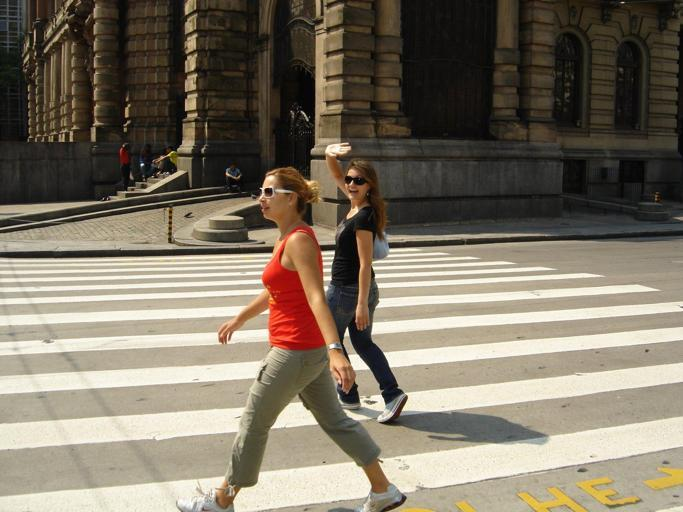

In [43]:
image = dataset[45]["image"]
image

In [44]:
segmenter = pipeline("image-segmentation", model="mmenendezg/segformer-b0_scene_parse_150", image_processor=image_processor)

'(ReadTimeoutError("HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out. (read timeout=10.0)"), '(Request ID: f95c3821-be7d-4fcc-8ed8-109189d1ca0c)')' thrown while requesting GET https://cdn-lfs.huggingface.co/repos/61/54/6154c216d4bd24cf0605c3e928f34ac642625de936a9a3b87b6eec16a6d55f83/0f4841ffc59ab3eba58369748ba68ce7cc9de88afd6ccc56c4ef4ca204b2a2f3?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1696736529&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NjczNjUyOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy82MS81NC82MTU0YzIxNmQ0YmQyNGNmMDYwNWMzZTkyOGYzNGFjNjQyNjI1ZGU5MzZhOWEzYjg3YjZlZWMxNmE2ZDU1ZjgzLzBmNDg0MWZmYzU5YWIzZWJhNTgzNjk3NDhiYTY4Y2U3Y2M5ZGU4OGFmZDZjY2M1NmM0ZWY0Y2EyMDRiMmEyZjM%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1df

In [45]:
segmenter(image)

[{'score': None,
  'label': 'wall',
  'mask': <PIL.Image.Image image mode=L size=683x512>}]